# LLM-based Question Answering given Email Data

The provided dataset contains email communication from the senior management of Enron company. The emails are divided across 45 plain text files, containing 96,107 messages. The corpus contains 2,205,910 lines and 13,810,266 words.

The task here is to build a solution pipeline (**preferably using LLMs**) to answer `30` questions, based on the provided email corpus. 

# RAG application on Email Data with Azure Open AI & Azure Cognitive Search

<img src="https://github.com/retkowsky/images/blob/master/azure_openai_logo.png?raw=true" width=400>

### Objective
Let's build an application that will analyse **Email documents using a RAG application.**

**Retrieval-Augmented Generation (RAG)** can exhibit variability in its implementation, but at a fundamental level, employing RAG within an AI-driven application involves the following sequential steps:


### Step 1: Read the email corpus from `data/email_data`

### Step 2: Read the Simple QA corpus from `data/qa_pairs/question_answer.jsonl`

### Step 3: Implement a solution approach (preferably LLM-based) to answer the questions from Simple QA corpus

- 3.1. **Data Preparation**
    - **Document Collection**: Read the emails and preprocess the email data.
    - **Chunking/Splitting**: Split documents into chunks for efficient retrieval.

- 3.2. **Indexer Training**
    - Train an indexer to create a dense vector representation of each passage.
        - **Embeddings**: Used a pre-trained model (OpenAI - text-ada-002) to generate embeddings for each passage.
        - **Index Creation**: Store these embeddings in a searchable index (Azure Search).
        
- 3.3. **Retriever Setup**
    - Implement a retriever to fetch the most relevant passages based on a query.
        - **Query Encoding**: Encode the user query into the same vector space.
        - **Similarity Search**: Use the index to find similar passages.
        
- 3.4. **Generative Model Integration** (GPT-3.5 or GPT-4) to use the retrieved passages as context.
    - **Contextual Prompting**: Format the retrieved passages and query as input for the model.
    - Use Azure OpenAI to generate responses using the retrieved passages as context. Make sure you have an Azure account and the OpenAI service configured.

- 3.5. **Inference Pipeline** :
    - Develop a pipeline to handle the entire process from user query to final answer.
        - **Input Handling**: Accept user queries.
        - **Retrieval**: Retrieve relevant passages using the retriever.
        - **Generation**: Generate the final answer using the generative model.
        
### Step 4: Implement one (or more) quantitative evaluation metrics to measure the performance of the generated answers 


### Steps
- Uploading embedded chunk documents into an Azure Cognitive Search Index
- Use of some Azure Cognitive Search queries to get relevant answers
- Use a GPT model to analyse the answer (summary, keywords generation)
- Get the text from the document and the reference to validate the proposed answer
- Chatbot experience using Azure Open AI to ask questions and get results provided by AI with references

### Process
<img src="https://github.com/retkowsky/images/blob/master/rag.png?raw=true" width=800>

#### Install the Required Libraries

In [1]:
# %pip install azure-search-documents==11.4.0b8
# %pip install --upgrade azure-identity

#### Import the basic libraries required

In [2]:
import datetime
import langchain
import openai
import os
import sys
import time
import uuid
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv

C:\Users\akhil\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")
print(f"Langchain version: {langchain.__version__}")

Python version: 3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]
OpenAI version: 1.33.0
Langchain version: 0.2.6


#### Get all the keys from `azure.env` file 

- Before we begin, we will have to create Azure OpenAI Service, Azure AI Service, Azure Search Service.
- This article describes how to get started with Azure OpenAI Service and provides step-by-step instructions to create a resource and deploy a model.
https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/create-resource?pivots=web-portal
- We can get the required keys from AZURE PORTAL: https://portal.azure.com/#home
https://www.c-sharpcorner.com/article/how-to-get-azure-open-ai-keys-and-endpoint/

In [4]:
load_dotenv("azure.env")

# Azure OPENAI Keys
azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_api_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_api_version = os.getenv("AZURE_API_VERSION")

# Azure Search Keys
azure_search_endpoint = os.getenv("AZURE_COGNITIVE_SEARCH_ENDPOINT")
azure_search_api_key = os.getenv("AZURE_COGNITIVE_SEARCH_API_KEY")
# Azure Cognitive search index
azure_search_index_name = os.getenv("AZURE_SEARCH_INDEX_NAME") 

# Azure Open AI models (Should be deployed on your Azure OpenAI studio)
azure_embed_deployment = os.getenv("AZURE_EMBED_DEPLOYMENT")
azure_gpt4_model = os.getenv("AZURE_GPT4O_DEPLOYMENT")  # GPT Model
azure_gpt35_model = os.getenv("AZURE_GPT35_DEPLOYMENT")

In [5]:
print(f"We will create the Azure Cognitive Search index: {azure_search_index_name}")

We will create the Azure Cognitive Search index: email-python-rag


#### Create AzureOpenAI Instance

In [6]:
from openai import AzureOpenAI

azure_openai_client = AzureOpenAI(
  azure_endpoint = azure_openai_endpoint, 
  api_key= azure_openai_api_key,  
  api_version= azure_api_version
)

#### Create vector store instance
Create instance of the AzureSearch class using the embeddings from above

In [7]:
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient

search_client = SearchClient(azure_search_endpoint, azure_search_index_name, AzureKeyCredential(azure_search_api_key))

## Step 1: Read the email corpus from `data/email_data`

In [8]:
email_dir = "./data/email_data/"

pdf_files = [file for file in os.listdir(email_dir)]
len(pdf_files)

45

We will chunk our Email Text documents, do the embeddings and save the content into Azure Cognitive Search

#### Loading and Processing the Email docs

The code reads text files from the "data/email_data/" directory using TextLoader from langchain_community.document_loaders. It loads each file into a Langchain Document object and appends it to a list, which is then returned. The load_docs function performs this task.

In [18]:
## Read the files in "data" Folder
from langchain_community.document_loaders import TextLoader
from langchain.docstore.document import Document as LangchainDocument

directory = './data/email_data/'

def load_docs(directory):
    documents = []
    for file in os.listdir(directory):
        file = directory+file
        loader = TextLoader(file)
        doc = loader.load()
        documents.append(doc[0])
    return documents

documents = load_docs(directory)

Calculate the no of words and tokens in each document

In [10]:
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")

In [11]:
for text in documents:
    source = text.metadata['source']
    text = text.page_content
    
    nb_tokens = len(encoding.encode(text))
    nb_words = len(text.split())
    print(
        f"{source}:\n- Number of words = {nb_words}\
        \n- Number of tokens = {nb_tokens} \n"
    )

./data/email_data/enronsent00:
- Number of words = 322792        
- Number of tokens = 495090 

./data/email_data/enronsent01:
- Number of words = 299786        
- Number of tokens = 451893 

./data/email_data/enronsent02:
- Number of words = 431744        
- Number of tokens = 612213 

./data/email_data/enronsent03:
- Number of words = 344976        
- Number of tokens = 524774 

./data/email_data/enronsent04:
- Number of words = 379862        
- Number of tokens = 679170 

./data/email_data/enronsent05:
- Number of words = 321401        
- Number of tokens = 495527 

./data/email_data/enronsent06:
- Number of words = 315198        
- Number of tokens = 487899 

./data/email_data/enronsent07:
- Number of words = 416704        
- Number of tokens = 608622 

./data/email_data/enronsent08:
- Number of words = 334221        
- Number of tokens = 495350 

./data/email_data/enronsent09:
- Number of words = 202936        
- Number of tokens = 710474 

./data/email_data/enronsent10:
- Number 

In [12]:
lens = [len(i.page_content.split()) for i in documents]

print("No of Documents: ", len(documents), "\nNo of words in whole corpus: ", sum(lens))

No of Documents:  45 
No of words in whole corpus:  13810266


## Step 2: Read the Simple QA corpus from `data/qa_pairs/question_answer.jsonl`

In [53]:
import json

def read_jsonl_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line.strip()))
    return data

# Example usage
file_path = './data/qa_pairs/question_answer.jsonl'
qa_json_list = read_jsonl_file(file_path)

print(qa_json_list[:3])

[{'question': 'What is the name of the person from the University who is handling the Excellence Fund awards, and when does he plan to have the Excellence Fund dinner?', 'ground_truth_answer': 'Ramesh Rao', 'predicted_answer': ''}, {'question': 'What is the name of the person who sent the initial email regarding pulling for Enron and the attached Attack_on_Taliban.mp3 file?', 'ground_truth_answer': 'Jim Easter', 'predicted_answer': ''}, {'question': 'What are the proposed terms for the rate increase according to the CPUC?', 'ground_truth_answer': 'A 1 cent/kwh charge for all customers', 'predicted_answer': ''}]


## Step 3: Implement a solution approach (preferably LLM-based) to answer the questions from Simple QA corpus

- 3.1. **Data Preparation**
    - **Document Collection**: Read the emails and preprocess the email data.
    - **Chunking/Splitting**: Split documents into chunks for efficient retrieval.

**clean_text(text):**

    - Converts HTML entities to their corresponding characters.
    - Replaces multiple newlines with a single space or a single newline, depending on whether they follow a period.
    - Replaces multiple spaces with a single space.
    - Removes leading and trailing whitespaces.
    - Optionally converts text to lowercase.
    - Removes non-ASCII characters.
    - Normalizes accented characters to their closest ASCII equivalents.
    - Expands common contractions (e.g., "can't" to "cannot").
**clean_documents(documents):**

    - Iterates through a list of documents.
    - Cleans the text content of each document using the clean_text function.
    - Creates a new list of cleaned documents with the cleaned text and original metadata.
    - Finally, it cleans a given list of documents using the clean_documents function.

In [19]:
import re
import html
import unicodedata
from langchain.schema import Document

def clean_text(text):
    # Replace HTML entities with their corresponding characters
    text = html.unescape(text)
    
    # Replace multiple newlines with a single newline if they occur after a full stop, else with a single space
    text = re.sub(r'(?<!\.)\n+', ' ', text)  # Replace newlines not after a period with a space
    text = re.sub(r'\.\n+', '.\n ', text)     # Replace newlines after a period with a single newline
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading and trailing whitespaces
    text = text.strip()
    
    # Convert text to lowercase (optional)
    #text = text.lower()
    
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    # Normalize accented characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii')
    
    # Expand common contractions (optional)
    contractions = {
        "can't": "cannot",
        "won't": "will not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'t": " not",
        "'ve": " have",
        "'m": " am"
    }
    for contraction, expansion in contractions.items():
        text = re.sub(contraction, expansion, text)
    
    return text

def clean_documents(documents):
    cleaned_documents = []
    for doc in documents:
        cleaned_text = clean_text(doc.page_content)
        cleaned_documents.append(Document(page_content=cleaned_text, metadata=doc.metadata))
    return cleaned_documents

documents = clean_documents(documents)

- **Importing the Text Splitter**: RecursiveCharacterTextSplitter is imported from langchain.text_splitter.
- **Defining Separators**: A list called separators is created, containing various characters and strings used to split the text. These include: *Used these seperators after some trial and error methods*
    - Newlines ('\r\n', '\n')
    - Punctuation marks ('.', '!', '?', ',', ';', ':')
    - Whitespace characters (' ', '\t')
    - Common email headers ('From:', 'To:', 'Cc:', 'Bcc:', 'Subject:', 'Date:', 'Message-ID:', 'In-Reply-To:', 'References:')
    - Quote and signature indicators ('>', '--')
    - HTML tags
##### By incorporating these additional steps, the text will be more standardized and easier to process, which can improve the performance of your RAG system.

- **Creating the Text Splitter**: An instance of RecursiveCharacterTextSplitter called splitter is created with the following parameters: *Found that chunk_size of 1024 is ideal for our case and took an overlap of 100 so that information will be retained in the next chunk*
    - separators: The list of separators defined earlier.
    - chunk_size=1024: Specifies the maximum size of each chunk.
    - chunk_overlap=100: Specifies the number of overlapping characters between consecutive chunks.
    - strip_whitespace=True: Removes leading and trailing whitespace from each chunk.

- **Splitting Documents**: The splitter.split_documents(documents) method is called to split the provided list of documents into smaller chunks based on the defined separators. The result is stored in the chunks variable.

In [20]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

separators = [
    '\r\n', '\n',  # Newlines
    '.', '!', '?', ',', ';', ':',  # Punctuation
    ' ', '\t',  # Whitespace
    'From:', 'To:', 'Cc:', 'Bcc:', 'Subject:', 'Date:', 'Message-ID:', 'In-Reply-To:', 'References:',  # Email headers
    '>', '--',  # Quote and signature
    '<p>', '<br>', '<div>', '<h1>', '<h2>', '<h3>', '<h4>', '<h5>', '<h6>'  # HTML tags
]

splitter = RecursiveCharacterTextSplitter(separators=separators, chunk_size=1024, chunk_overlap=100, strip_whitespace=True)


chunks = splitter.split_documents(documents)

In [21]:
print("We created about ", len(chunks), "chunks of data")

We created about  94033 chunks of data


In [22]:
text_lens = [len(i.page_content) for i in chunks]
chunk_lens = [len(encoding.encode(i.page_content)) for i in chunks]

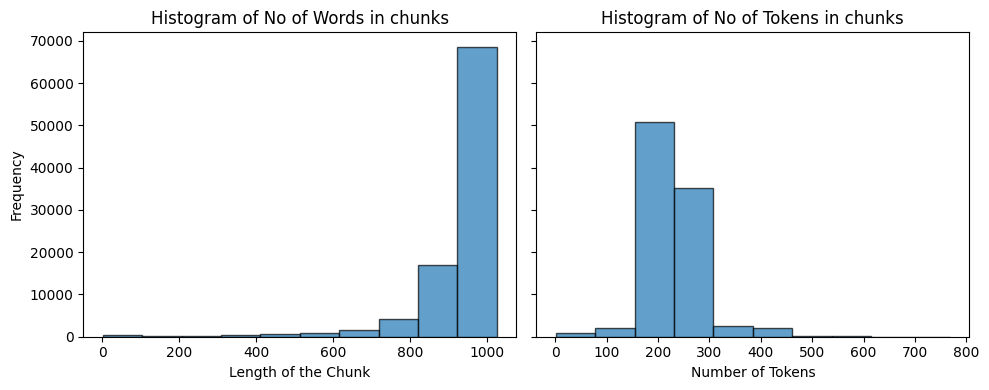

In [54]:
import matplotlib.pyplot as plt

# Plotting the histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

ax1.hist(text_lens, alpha=0.7, edgecolor='black')
ax1.set_title('Histogram of No of Words in chunks')
ax1.set_xlabel('Length of the Chunk')
ax1.set_ylabel('Frequency')

ax2.hist(chunk_lens,alpha=0.7, edgecolor='black')
ax2.set_title('Histogram of No of Tokens in chunks')
ax2.set_xlabel('Number of Tokens')

# Adjust layout
plt.tight_layout()

# Display the histograms
plt.show()

- 3.2. **Indexer Training**
    - Train an indexer to create a dense vector representation of each passage.
        - **Embeddings**: Used a pre-trained model (OpenAI - text-ada-002) to generate embeddings for each passage.
        - **Index Creation**: Store these embeddings in a searchable index (Azure Search).

First Create an Index on Azure Search and give the meta data

---My **Index_name** and **type** are as follows:

              id - String (Created Random and unique ids)
       meta_data - String (Basically the file from which the chunk is created)
           chunk - String (The chunked data)
    chunk_number - Int32  (Numeric identifier for chunk - Unique and sortable)
     text_vector - SingleCollection (The embedding for the chunk - 1536 dimension)

In [26]:
import requests, json

def index_stats(index_name, azure_cs_endpoint, azure_cs_key):
    """
    Get statistics about Azure Cognitive Search index
    Inputs: index name, endpoint and key
    Output: Index statistics
    """
    # Get url of the index
    url = (
        azure_cs_endpoint
        + "/indexes/"
        + index_name
        + "/stats?api-version=2021-04-30-Preview"
    )
    
    # Request
    headers = {
        "Content-Type": "application/json",
        "api-key": azure_cs_key,
    }
    # Get the response
    response = requests.get(url, headers=headers)
    print("Azure Cognitive Search index status for:", index_name, "\n")
    
    if response.status_code == 200:
        res = response.json()
        print(json.dumps(res, indent=2))
        document_count = res["documentCount"]
        storage_size = res["storageSize"]
    
    else:
        print("Request failed with status code:", response.status_code)

    return document_count, storage_size

In [28]:
document_count, storage_size = index_stats(azure_search_index_name, azure_search_endpoint, azure_search_api_key)

Azure Cognitive Search index status for: email-python-rag 

{
  "@odata.context": "https://newemailsearch.search.windows.net/$metadata#Microsoft.Azure.Search.V2021_04_30_Preview.IndexStatistics",
  "documentCount": 94033,
  "storageSize": 2518331071
}


#### The code to read the chunk and embed it and store it into the Azure Search Index

In [30]:
def get_embeddings_from_chunks(chunks, embedding_model = azure_embed_deployment):
    count = 0
    vector_doc = []

    for chunk in chunks:
        uploaded_chunk = {}
        meta_data = chunk.metadata['source']
        chunk_data = chunk.page_content
        embedding = azure_openai_client.embeddings.create(input=chunk_data, model=embedding_model)
        #embedding = embedding.data[0].embedding

        uploaded_chunk['id'] = str(uuid.uuid4())
        uploaded_chunk['meta_data'] = meta_data
        uploaded_chunk['chunk'] = chunk_data
        uploaded_chunk['chunk_number'] = count
        uploaded_chunk['text_vector'] = embedding.data[0].embedding
        vector_doc.append(uploaded_chunk)
        result = search_client.upload_documents(documents=[uploaded_chunk])

        count = count + 1
        if (count%1000 == 0):
            print(count, " Thousand Chunks done - Sleep for 1 seconds")
            time.sleep(1)
    
    #return vector_doc

In [31]:
# Upload id, meta_data, chunk_number, text_vector and chunk to the Azure Search Index
## UNCOMMENT TO RUN
#get_embeddings_from_chunks(chunks[0:3])

In [35]:
# import pandas as pd
# dict_list = pd.read_csv("email_embedded_data.csv")
# dict_list.head()

,id,meta_data,chunk_number,text_vector,chunk
0,01c618b2-f6c7-49eb-88b4-5a47fefe7595,./data/email_data/enronsent00,0,"[-0.0346812978386879, -0.018227072432637215, 0...",attached are two files that illustrate the fol...
1,ca822867-3388-4dfd-88ee-1cda91176ee6,./data/email_data/enronsent00,1,"[-0.04456092417240143, -0.0012525849742814898,...",". your input (i.e., a self assessment, manager..."
2,2daa2a28-5367-4b4f-86fd-251639ca1d2e,./data/email_data/enronsent00,2,"[-0.00777137978002429, -0.007440682966262102, ...",. if you have any questions about this process...
3,f5c8751c-ea0c-4558-865e-fde24050bb22,./data/email_data/enronsent00,3,"[0.003138926113024354, -0.021752916276454926, ...",. i have been preaching the tremendous growth ...
4,1968161c-098d-47f8-92b2-cb096cfa8293,./data/email_data/enronsent00,4,"[0.006046305876225233, -0.017093107104301453, ...",. fast-forward to summer 2000. exodus is now w...


In [32]:
document_count, storage_size = index_stats(azure_search_index_name, azure_search_endpoint, azure_search_api_key)

Azure Cognitive Search index status for: email-python-rag 

{
  "@odata.context": "https://newemailsearch.search.windows.net/$metadata#Microsoft.Azure.Search.V2021_04_30_Preview.IndexStatistics",
  "documentCount": 94033,
  "storageSize": 2518331071
}


In [33]:
print(f"Number of documents in the index = {document_count}")
print(f"Size of the index = {round(storage_size / (1024 * 1024), 2)} MB")

Number of documents in the index = 94033
Size of the index = 2401.67 MB


#### Testing the Azure GPT model

In [35]:
messages_history = []

response = azure_openai_client.chat.completions.create(
    model = azure_gpt4_model,
    messages=[
        {"role": "user", "content": "What is Azure AI"}
    ]
)

print(response.choices[0].message.content)

Azure AI is Microsoft’s suite of artificial intelligence tools and services hosted on the Azure cloud platform. It includes technologies for building, deploying, and managing AI applications. These tools are designed to help developers and organizations incorporate AI capabilities into their applications and workflows. Here are some key components of Azure AI:

1. **Azure Machine Learning**:
   - A cloud-based environment to train, deploy, and manage machine learning models. It offers a range of capabilities, from automated machine learning to a robust model management platform.

2. **Cognitive Services**:
   - A collection of APIs and services that allow developers to embed AI into their applications. These services cover vision, speech, language, knowledge, and search functionalities.
   - Examples include Facial Recognition, Text Analytics, Speech-to-Text, and Language Understanding (LUIS).

3. **Azure Bot Services**:
   - Tools for building, testing, and deploying chatbots. This se

- 3.3. **Retriever Setup**
    - Implement a retriever to fetch the most relevant passages based on a query.
        - **Query Encoding**: Encode the user query into the same vector space.
        - **Similarity Search**: Use the index to find similar passages.
        
- 3.4. **Generative Model Integration** (GPT-3.5 or GPT-4) to use the retrieved passages as context.
    - **Contextual Prompting**: Format the retrieved passages and query as input for the model.
    - Use Azure OpenAI to generate responses using the retrieved passages as context. Make sure you have an Azure account and the OpenAI service configured.

In [70]:
context = """
You have access to an email data dump that contains information about various projects, client communications, and internal discussions. Here are some points from the emails:
Use this information to answer any questions related to these topics. Give answers precisely to only the question asked.
"""

In [68]:
def azure_openai(context, prompt, gptmodel, temperature=0.5, max_tokens=200):
    """
    Get Azure Open AI results
    Inputs: prompt; gptmodel, temperature and max tokens
    Outputs: answer (text)
    """
    # Context definition
    # Define the context variable with relevant email information
    
    
    # Get results using Azure open AI
    response = azure_openai_client.chat.completions.create(
        model = gptmodel,
        messages= [
            {"role": "system", "content": context},
            {"role": "user", "content": prompt},
        ],
        temperature=temperature,
        max_tokens=max_tokens,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None,
    )
        
    # Get answer
    answer = response.choices[0].message.content

    return answer

In [44]:
print(f"Azure OpenAI model to use: {azure_gpt4_model}")

Azure OpenAI model to use: gpt_4_email


In [47]:
print(azure_openai(context, "Who are you?", azure_gpt4_model))

I am an AI developed by OpenAI, designed to assist with processing and answering questions based on the provided information. How can I help you today?


In [48]:
print(azure_openai(context, "Qui es-tu?", azure_gpt4_model))

Je suis un assistant virtuel conçu pour répondre à vos questions et vous aider avec des informations basées sur les données disponibles. Comment puis-je vous aider aujourd'hui?


In [49]:
print(azure_openai(context, "What can you do for me?", azure_gpt4_model))

I can provide precise answers to questions related to the projects, client communications, and internal discussions mentioned in the email data dump. Please ask a specific question related to these topics.


###### Ask your own data 

We can ask any questions related with the documents we have processed. You can ask in any language.

- 3.5. **Inference Pipeline** :
    - Develop a pipeline to handle the entire process from user query to final answer.
        - **Input Handling**: Accept user queries.
        - **Retrieval**: Retrieve relevant passages using the retriever.
        - **Generation**: Generate the final answer using the generative model.

# RAG APPROACH - 1

1. Used `Semantic + Hybrid` approach to get the best and most relevant documents (Tried `simple` vector, `semantic` and `hybrid` approaches but `Semantic + Hybrid` outperformed others)
2. Used `GPT-4` model to answer my query
3. Used `text-embedding-ada-002` text embedding

In [50]:
from azure.search.documents.models import QueryType
import math

def ask_your_own_data(context, query, gptmodel, topn=5, min_score=0.5, max_tokens=200):
    """
    Qna with Azure Cognitive Search and Azure Open AI.
    We will retrieve the search index results and then we can process these results with Azure Open AI.
    We will have a summary, with the documents parts and the document source informations.
    
    Inputs: query, vector store, gptmodel, topn and min score
    Outputs: Printing results
    """
    # Get vector search results from Azure Cognitive Search
#     results_simple = search_client.search(search_text=query,
#                                    query_type=QueryType.SIMPLE,
#                                    semantic_configuration_name="semantic_config",
#                                    top=math.ceil(topn/2))
    
    # Get semantic + Hybrid search results from Azure Cognitive Search
    results = search_client.search(search_text=query,
                                   query_type=QueryType.SEMANTIC,
                                   semantic_configuration_name="semantic_config",
                                   top=topn)
    
    fulltext_list = []
    meta_data_list = []
    chunk_number_list = []
    confidence_list = []
    
    for result in results:
        reference = result['chunk']
        meta_data = result["meta_data"]
        chunk_number = result["chunk_number"]
        confidence = result["@search.score"]
        
        fulltext_list.append(reference)
        meta_data_list.append(meta_data)
        chunk_number_list.append(chunk_number)
        confidence_list.append(confidence)

    fulltext = "".join(fulltext_list)
    prompt = f"Based on the following information:\n\n{fulltext}\n\nAnswer the following question:\n\n{query}"
    
    answer_reference = azure_openai(context, prompt, gptmodel, max_tokens = max_tokens)
    print("\033[1;31;34m")
    print("Azure Open AI results:\n\n", answer_reference)
    print("\033[1;31;35m")
    print(
        "[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.\n"
    )

    ## Uncomment below lines to diplay reference documents
#     for i in range(len(fulltext_list)):
#         # Get Azure Cognitive Search result
#         reference = fulltext_list[i]
#         #ref = reference.__dict__
#         meta_data = meta_data_list[i]

#         # Get source information
#         #source = reference.metadata
#         chunk_number = chunk_number_list[i]
#         confidence = confidence_list[i]

#         # Printing results
#         print(f"\033[1;31;32mDocument reference {i+1}:\n")
#         print(reference)
#         print("\033[1;31;91m")
#         print(
#             f"Document source: {meta_data} Page: {chunk_number} with confidence = {confidence}"
#         )
#         print()
    
    return answer_reference, fulltext_list

In [51]:
query = "What is the name of the person who is handling the Excellence Fund awards and and when does he plan to have the Excellence Fund dinner?"

ask_your_own_data(context, query, azure_gpt4_model, topn=5)


Azure Open AI results:

 The person handling the Excellence Fund awards is Ramesh Rao (associate dean), and he plans to have the Excellence Fund dinner in the fall.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.



('The person handling the Excellence Fund awards is Ramesh Rao (associate dean), and he plans to have the Excellence Fund dinner in the fall.',
 ['. i have an intuitive explanation based on probability trees. my wishes of a good weekend, giuseppe vince, good morning. as you may know, last thur. enron honored this year is recipients of the enron mba excellence fund scholars at a dinner in austin. in addition to the three recipients, business school dean may and several of my colleagues, enron attendees included sally beck, cindy justice, karen marshall (newly-appointed coordinator of higher education initiatives for enron community relations dept.) and rick causey. i write you at this time to advise you i had occasion to discuss two current enron/ut issues with rick: i. spring 2001 conference participation by jeffrey k. skilling ii. ut participation in enrontraining activities per my conversation with rick last thur., i followed up on that discussion with an e-mail this morn that touche

## Running all questions

In [20]:
for qa_pair in qa_json_list:
    print("===============================================================")
    qa_pair['predicted_answer'], qa_pair['reference_context'] = ask_your_own_data(context, qa_pair['question'], azure_gpt4_model, topn=5)


Azure Open AI results:

 The person from the University handling the Excellence Fund awards is Ramesh Rao, the associate dean. He plans to have the Excellence Fund dinner in the fall.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.

Document reference 1:

thanks! elyse susan white <susan.white@bus.utexas.edu> on 04/06/2000 10:19:12 am hi elyse - i just spoke with ramesh rao (associate dean). he has not yet made the excellence fund awards, which are also part of the enron endowment. he would like to have the dinner in the fall, when all of the awardees have been chosen. he felt that a dinner the end of april would conflict with a major e-commerce conference we are having here, and the enron awards would get the attention they deserve in the fall. the other advantage of a fall dinner is that the new students will be here, and if we have a big announcement then, they can see what they have to look forward to. will this work for you? thanks. sue sue:


Azure Open AI results:

 The author of the column in the San Francisco Chronicle that discusses the energy situation and criticizes Governor Gray Davis is Dan Schnur.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.

Document reference 1:

. e-mail the writers at zcoile@sfchronicle.com . and cber= thelsen@sfchronicle.com ., zachary coile reported from washington, d.c., an= d christian berthelsen in san francisco. ?2001 san francisco chronicle = page a - 1 davis opens another new power plant pittsburg facility wil= l generate 555 megawatts bernadette tansey, chronicle staff writer tuesda= y, july 10, 2001 ?2001 san francisco chronicle url: http://www.sfgate.co= m/cgi-bin/article.cgi?f=3d/c/a/2001/07/10/mn175828.dtl pittsburg -- wo= rkers were still scraping wet concrete on support columns as gov. gray davi= s celebrated the startup of a new power plant in pittsburg yesterday -- the= latest in a string of openings davis hopes will help california "b


Azure Open AI results:

 The provided information does not include any email subjects, so it is not possible to determine the subject set for an appointment on 04/03/2000 at 04:00 PM.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.

Document reference 1:

:40:23 pm</omnicreateddate> <omniform>appointment</omniform> <omniexcludefromview>d</omniexcludefromview> <omni$publicaccess>1</omni$publicaccess> <omnichair>cn=3djohn m forney/ou=3dhou/o=3dect</omnichair> <omniorgtable>c0</omniorgtable> <omni$busyname>cn=3djohn m forney/ou=3dhou/o=3dect</omni$busyname> <omni$busy>1</omni$busy> <omni$busypriority>1</omni$busypriority> <omniprincipal>cn=3djohn m forney/ou=3dhou/o=3dect</omniprincipal> <omniappointmenttype>0</omniappointmenttype> <omni_viewicon>160</omni_viewicon> <omnicalendardatetime>04/03/2000 03:00:00 pm</omnicalendardatetime> <omnistartdate>04/03/2000 03:00:00 pm</omnistartdate> <omnistartdatetime>04/03/2000 03:00:00 pm</omnistartdatetime> <o


Azure Open AI results:

 Judy Hernandez did not email Amber Ebow at 3:27 PM. Instead, Amber Ebow emailed Julissa Marron at 3:27 PM on 02/11/2000.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.

Document reference 1:

. matt. 5:13-15. we should be bringing peace to our jobs and not be the cause of confusion. we should be the ones= =20 to bring our gifts & talents to the table to help in whatever area god has chosen for us to work in. col.3:23-24 "whatever you= =20 do, work at it with all your heart, as working for the lord, not for men, = =20 since you know that you will receive an inheritance from the lord as a=20 reward. it is the lord christ you are serving. > > > "and still i rise!" > judy hernandez on 02/11/2000 03:59:57 pm amber ebow 02/11/2000 03:27 pm julissa marron@enron 02/11/2000 03:21 pm - att00032.jpg amber ebow 02/11/2000 03:27 pm julissa marron@enron 02/11/2000 03:21 pm - att00032.jpg amber ebow 02/11/2000 03:27 pm julissa marron@e


Azure Open AI results:

 The date of Vince Kaminski's presentation at the University of California at Berkeley is not explicitly stated in the provided information. However, there are mentions of potential dates: September 10th or 17th, and also a reference to a presentation that took place before October 23, 2000.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.

Document reference 1:

. maybe we could combine another presentation in during the same visit. what do you think? ashley vince j kaminski@ect 08/30/2000 08:03 am shmuel, let is see if we can either rearrange the seminar speakers or change the date of our visit to the campus. ashley baxter, our coordinator is very efficient and got a faculty room for a presentation on monday morning on the 16th. vince dear vince. i spoke too soon. apparently the seminar slot on the 16 was already filled. i will see if i can switch the speaker for that week to the following week. in any case we are on for 


Azure Open AI results:

 James Stiglitz criticizes the IMF and U.S. Treasury policy for their "conditionality" approach, which imposes far-reaching internal changes on countries as a condition for loans. He argues that these policies are driven by ideology rather than scientific economic models and that they often lead to negative outcomes, such as increased ethnic conflict and economic instability. He also criticizes the policymakers for adhering to the "theory of escalating commitment," where the costs of mistakes are borne by others, while admitting mistakes would cost the policymakers themselves.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.

Document reference 1:

. "so you ask yourself the question:  wouldo you remain silent and play the system, or do you speak out?' why have a job with responsibility if you do not speak out?" the imf imposed its plan, and just as stiglitz and the world bank had predicted, ethnic conflict swept across ind


Azure Open AI results:

 Lou Pai is set to lead the Office of the Chairman in the newly formed Enron Energy Services (EES).

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.

Document reference 1:

. this review process will take time as it will require approval of the creditors' committee. we will update you periodically on our process. personnel matters as a result of our current situation, we have made many personnel changes over the past several months to maximize the value of the organization. office of the chairman - enron corp jeff mcmahon, executive vice president and chief financial officer, has been added to the office of the chairman of enron corp along with ken lay and greg whalley. among other things, jeff has been working on the business plan for reorganization in chapter 11 and is the primary contact with the newly formed creditor is committee. treasurer - enron corp ray bowen was elected to executive vice president, finance and trea


Azure Open AI results:

 The request for flexibility on the payment of the September 30 principal payment for Panther was made by someone involved in the restructuring process of the Panther loan. They asked if they could wait until the distribution payment date in November before making the principal payment. This request was made to give a few more weeks to finalize the restructuring negotiations and perhaps enable them to defer the payment until June. This would also allow DPR to make a larger dividend distribution to both Enron and Chris Cline.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.

Document reference 1:

. our next meeting will be next wednesday, november 1 in eb38c2. thanks again for the hard work. mark senior counsel, ena phone: 713-345-8897 facsimile: 713-646-3940 e-mail: mark.greenberg@enron.com alan, please confirm that you have told mike that it is required that legal be consulted on such a waiver. mark this memo is being sen


Azure Open AI results:

 Gerald is mentioned in relation to overseeing work on the Napoleonville project and collaborating on the crawfish right-of-way work. There are no specific events or travels mentioned for Gerald in the provided documents.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.

Document reference 1:

. we will monitor the web site and update the questions periodically. please review the letter and faq and let me know of any changes or comments by tomorrow evening, tuesday, 5:00 p.m. our goal is to get these documents to the customers by wednesday, october 3rd. we appreciate your input in this process. do not hesitate to call if you have questions. (ext. 3-7637) << file: winterops_followup.doc >> << file: frequently asked questions 1.doc >> thanks. lynn there was no attachment this is to review what will be reviewed with stan on the 12th. cvb ladies, the holiday shopping card is a wonderful holiday tradition. the card entitles the 


Azure Open AI results:

 The special rates for Enron employees are available for the following upcoming March games:

- March 1 - L.A. Clippers
- March 3 - Golden State Warriors
- March 6 - Vancouver Grizzlies (Clyde Drexler's jersey retirement)
- March 8 - San Antonio Spurs
- March 14 - Phoenix Suns
- March 16 - Utah Jazz
- March 26 - L.A.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.

Document reference 1:

. thanks again for passing the information on. i hope all is well! > here are the upcoming blazer specials for all enron employees! > > > blue section (lower level endzone) - $47 (normally $69 - available for > limited games) > > purple section (upper level center) - $20 (normally $23) > > tan section (upper level behind basket) - $10 > > > *bonus* - each ticket comes with worth of $3 blazer bucks (good for food > and > beverage in the arena) > > ** preferred seating is still available for games sold out in the general > seating ** > > to 


Azure Open AI results:

 Pacific Gas and Electric Company cited the following reasons for filing for Chapter 11 reorganization:
1. Unreimbursed energy costs increasing by more than $300 million per month.
2. Continuing decisions by the California Public Utilities Commission (CPUC) that economically disadvantage the company.
3. Unsuccessful negotiations with Governor Gray Davis and his representatives.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.

Document reference 1:

.com> 04/06/2001 12:46 pm pacific gas and electric company files for chapter 11 reorganization business wire 04/06/01, 12:34p (copyright , 2001, business wire) san francisco--(business wire)--april 6, 2001--pacific gas and electric company, the utility unit of pg&e corporation (nyse: pcg), today filed for reorganization under chapter 11 of the u.s. bankruptcy code in san francisco bankruptcy court. the company said it is taking this action in light of its unreimbursed energy cos


Azure Open AI results:

 The email data provided does not contain any information regarding GS's (Goldman Sachs) valuation of ENE (Enron) shares.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.

Document reference 1:

.com/isbemail.asp?ticker=ene&ttype=s ene andrew fastow sells 83037 enron corp or shares. the following hyperlink will take you into the transaction page for enron corp or so you can view more details and put the activity into historical context. http://www.insiderscores.com/isbemail.asp?ticker=ene&ttype=s ene steven kean sells 4560 enron corp or shares. the following hyperlink will take you into the transaction page for enron corp or so you can view more details and put the activity into historical context. http://www.insiderscores.com/isbemail.asp?ticker=ene&ttype=s ene richard causey sells 7814 enron corp or shares. the following hyperlink will take you into the transaction page for enron corp or so you can view more details and p


Azure Open AI results:

 The provided email does not indicate that Janet Dietrich expressed any concerns about the EES operations in Alberta and Ontario. The email primarily discusses leadership changes and the roles of various individuals within EES, including Janet Dietrich's new role as Chief Operating Officer. There is no mention of any specific concerns expressed by her regarding the operations in Alberta and Ontario.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.

Document reference 1:

. i spoke yesterday afternoon with george caraghiaur, exelergy is=20 vice president, canada, about ebt express. caraghiaur believes that the=20 site "will provide the essential technology for opening ontario is electrici= ty=20 market in an efficient manner." that is no small undertaking as there are= =20 an expected 300 players that will need to communicate with each other in=20 ontario once competition begins. deregulation is happening in canada on a prov


Azure Open AI results:

 The overall mood among employees seems to be one of caution and concern regarding the possibility of illegal transactions, specifically related to "gifting clubs" that are suspected to be illegal pyramid schemes. Additionally, there is a proactive and somewhat constructive approach towards improving the upcoming employee meeting, with efforts being made to address previous technical issues and enhance the viewing experience for employees.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.

Document reference 1:

.doc - enron risk assessment matrix.doc fyi below find the proposed message that we intend to send to all us employees= =20 regarding the alleged "gifting clubs." i wanted you to be aware of the=20 company is position concerning these "gifting clubs" in the event that your= =20 staff was to receive any questions concerning this matter. thank you. kriste sullivan eb 4861 ext. 37557 =09kriste sullivan =09sent by: tanja

In [21]:
df = pd.DataFrame(qa_json_list)
df.head()

,question,ground_truth_answer,predicted_answer,reference_context
0,What is the name of the person from the Univer...,Ramesh Rao,The person from the University handling the Ex...,[thanks! elyse susan white <susan.white@bus.ut...
1,What is the name of the person who sent the in...,Jim Easter,The name of the person who sent the initial em...,[. jim (see attached file: attack_on_taliban.m...
2,What are the proposed terms for the rate incre...,A 1 cent/kwh charge for all customers,The proposed terms for the rate increase accor...,[. as we wait with anticipation to hear what t...
3,Who is the author of the column in the San Fra...,Rob Morse,The author of the column in the San Francisco ...,[. e-mail the writers at zcoile@sfchronicle.co...
4,What is the anticipated worth per share of ENE...,$68,The anticipated worth per share of ENE accordi...,[apparently gs is going to issue a report sayi...


##### Store and save the results in a csv file

In [22]:
df.to_csv("answers_gpt4_eval.csv", index = False)

In [98]:
import pandas as pd

In [ ]:
pd.read_csv()

## Step 4: Implement one (or more) quantitative evaluation metrics to measure the performance of the generated answers 

##### Evaluate LLM using LLM(OpenAI - gtp-4o and Embeddings on Azure AI

##### Used Azure AI's Evaluation mechanism to generate the Evaluation Metrics - We downloaded the generated "answers_gpt4_eval.csv" to obtain the evaluation results


![title](./images/eval_from_azureai.png)

In [91]:
def plot_evaluation(eval_results):
    # Plotting each column as a separate bar plot
    plt.figure(figsize=(12, 8))

    for i, column in enumerate(eval_results[['gpt_similarity', 'gpt_coherence', 'gpt_fluency','gpt_groundedness', 'gpt_relevance']]):
        plt.subplot(2, 3, i + 1)  # Adjust subplot layout as per your preference
        value_counts = eval_results[column].value_counts().sort_index()
        plt.bar(value_counts.index, value_counts.values, edgecolor='black')
        #plt.title(column)
        plt.xlabel(f"{column} - Score")
        plt.ylabel('Frequency')
        plt.xticks(range(1, 6))  # Set x-axis ticks to be 1-5

        # Calculate average score
        average_score = eval_results[column].mean()
        plt.title(f"{column.split('_')[1].capitalize()} Average Score = {average_score:.2f}")

        plt.xlim(0.5, 5.5)  # Set x-axis limits to be slightly beyond 1 and 5 for better spacing
        plt.tight_layout()

    plt.show()

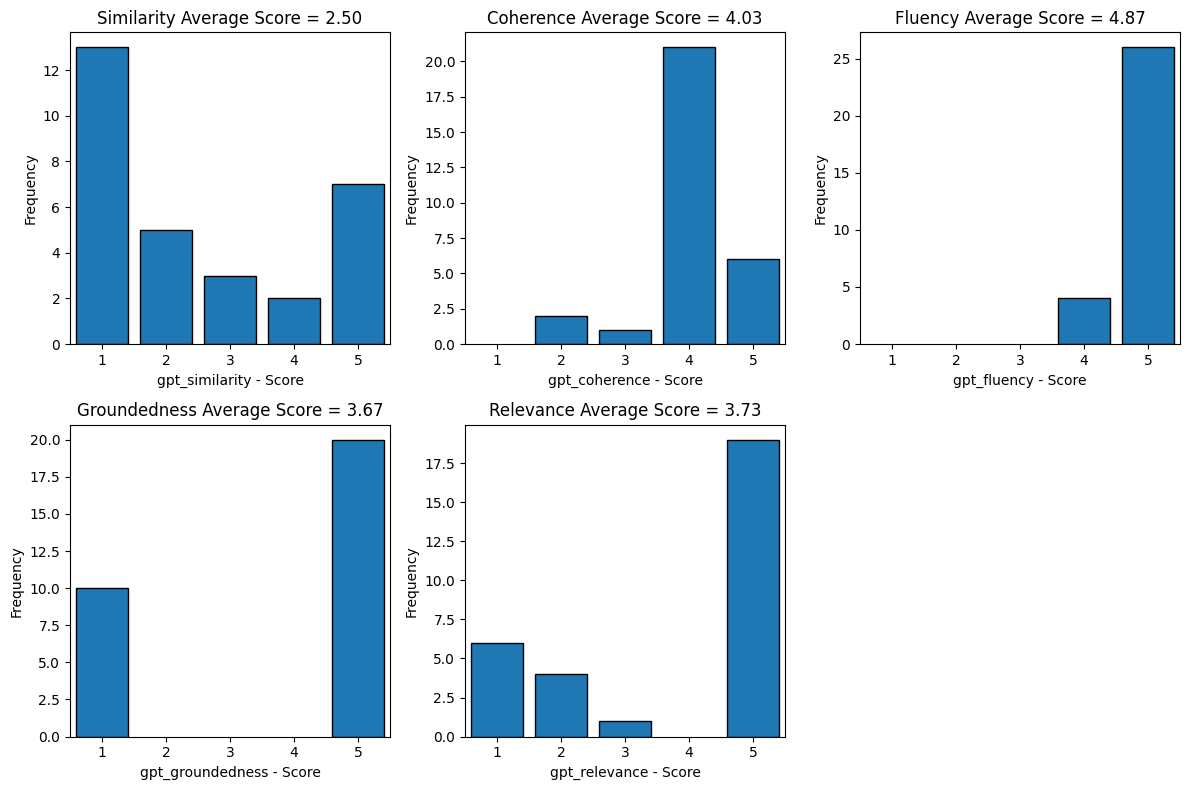

In [90]:
eval_results = pd.read_csv("evaluation_mighty_net_ch57f42tx6_Output_Table_07-12-2024-20-14.csv")
plot_evaluation(eval_results)

#### We can see that most of the questions scored more than 3 in average metrics, which makes our model decent but still there's scope for improvement

## PLACEHOLDER: any additional optimizations, evaluations and model benchmarks

#### Let us do some Engineering and let's see if the results improve

Let us try ADVANCED RAG as mentioned in this paper: https://arxiv.org/pdf/2312.10997


Gao, Y., Xiong, Y., Gao, X., Jia, K., Pan, J., Bi, Y., Dai, Y., Sun, J., Wang, M., & Wang, H. (2023). Retrieval-Augmented Generation for Large Language Models: A Survey. Shanghai Research Institute for Intelligent Autonomous Systems, Tongji University; Shanghai Key Laboratory of Data Science, School of Computer Science, Fudan University; College of Design and Innovation, Tongji University. 

![title](./images/advanced_rag.png)

# RAG APPROACH - 2
Let us use llama_index and Azure to do query rerouting. Here,

1. We generate `n-sub questions` drom Original Query
2. Get `sub answer` for each sub question
3. Use these `n-sub Question: Answer` pairs as context to our GPT model
4. Now get the `Answer from Original Query` with `context from step 3`
5. Used the `semantic+hybrid` approach to get relevant chunks

NOTE: There are several ways of implementing this approach, let's fix the above four steps for this iteration

In [19]:
# !pip install llama_index
# %pip install llama-index-llms-openai
# %pip install llama-index-embeddings-azure-openai
# %pip install llama-index-llms-azure-openai
# %pip install llama-index-embeddings-openai
# %pip install llama-index-graph-stores-nebula

# !pip install wget
# %pip install llama-index-vector-stores-azureaisearch
# %pip install azure-search-documents==11.4.0
# %llama-index-embeddings-azure-openai
# %llama-index-llms-azure-openai

In [56]:
from llama_index.core import PromptTemplate
from llama_index.core import Settings
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
#import logging
import sys

In [58]:
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from IPython.display import Markdown, display
from llama_index.core import (
    SimpleDirectoryReader,
    StorageContext,
    VectorStoreIndex,
)
from llama_index.vector_stores.azureaisearch import AzureAISearchVectorStore
from llama_index.vector_stores.azureaisearch import (
    IndexManagement,
    MetadataIndexFieldType,
)

In [59]:
llm = AzureOpenAI(
    model='gpt-4o',
    deployment_name=azure_gpt4_model,
    api_key=azure_openai_api_key,
    azure_endpoint=azure_openai_endpoint,
    api_version=azure_api_version,
)

# You need to deploy your own embedding model as well as your own chat completion model
embed_model = AzureOpenAIEmbedding(
    model="text-embedding-ada-002",
    deployment_name=azure_embed_deployment,
    api_key=azure_openai_api_key,
    azure_endpoint=azure_openai_endpoint,
    api_version=azure_api_version,
)

In [60]:
credential = AzureKeyCredential(azure_search_api_key)
# Use index client to demonstrate creating an index
index_client = SearchIndexClient(
    endpoint=azure_search_endpoint,
    credential=credential,
)

# Use search client to demonstration using existing index
search_client = SearchClient(
    endpoint=azure_search_endpoint,
    index_name=azure_search_index_name,
    credential=credential,
)

In [61]:
from llama_index.core import Settings

Settings.llm = llm
Settings.embed_model = embed_model

In [62]:
from llama_index.core import PromptTemplate
 
query_gen_str = """\
You are a helpful assistant that generates multiple search queries based on a \
single input query. Generate {num_queries} search queries, one on each line, \
related to the following input query:
Query: {query}
Queries:
"""
query_gen_prompt = PromptTemplate(query_gen_str)

def generate_queries(query: str, llm, num_queries: int = 5):
    response = llm.predict(
        query_gen_prompt, num_queries=num_queries, query=query
    )
    # assume LLM proper put each query on a newline
    queries = response.split("\n")
    queries_str = "\n".join(queries)
    print(f"Generated queries:\n{queries_str}")
    return queries

In [65]:
import json
def read_jsonl_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line.strip()))
    return data

# Example usage
file_path = './data/qa_pairs/question_answer.jsonl'
qa_json_list = read_jsonl_file(file_path)

for qa_pair in qa_json_list:
    print("GENERATING SUB QUERIES........")
    queries = generate_queries(qa_pair['question'], llm)
    answers = []

    for question in queries:
        ans, _ = ask_your_own_data(context, question, 'gpt35_turbo', topn=5, max_tokens=50)
        answers.append(ans)
        
    context = """You have access to an email data dump. Use this information to answer any questions related to these topics.
    Also use the below question answer pairs for reference.\n"""
    
    for i in range(len(answers)):
        context += f"Q: {queries[i]}\nA: {answers[i]}\n\n"
    
    
    qa_pair['predicted_answer'], qa_pair['reference_context'] = ask_your_own_data(context, qa_pair['question'], azure_gpt4_model, topn=5, max_tokens=300)
    print("===============================================================")

GENERATING SUB QUERIES........
Generated queries:
1. Who is responsible for the Excellence Fund awards at the University?
2. When is the Excellence Fund dinner scheduled at the University?
3. Who manages the Excellence Fund awards at the University?
4. What is the date for the Excellence Fund dinner organized by the University?
5. Who is the University staff member in charge of the Excellence Fund awards and dinner?

Azure Open AI results:

 Ramesh Rao, the associate dean, is responsible for the Excellence Fund awards at the University.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 The Excellence Fund dinner at the University is scheduled for Tuesday, October 16th.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 Ramesh Rao, the associate dean, manages the Excellence Fund awards at the University.

[Note] This summary is generated by an AI (Azure Open AI)


Azure Open AI results:

 The email mentions that "apparently gs is going to issue a report saying ene is worth $68 a share." This indicates that the GS report predicts the stock price of ENE to be $68 per share.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 Goldman Sachs issued a brief report following their visit with Enron management on Monday, revising their price target to $68/share. This information suggests that the expected ENE share value from Goldman Sachs is $68.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 Goldman Sachs issued a brief report following their visit with Enron management on Monday, revising their price target for ENE stock to $68/share. They discussed the recent issues driving downward pressure on the stock and hosted a conference call to discuss their

[Note] This summary is generated by an AI (Azure Open AI). Examine and us


Azure Open AI results:

 I'm sorry, I couldn't locate the specific date when Judy Hernandez sent an email to Amber Ebow at 3:27 PM from the provided information.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 I'm sorry, I couldn't find the specific timestamp for Judy Hernandez's email to Amber Ebow at 3:27 PM in the provided data. If you have any other questions or if there's anything else I can help you with, please

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 I'm sorry, I couldn't find any relevant information in the provided data to determine the date Judy Hernandez emailed Amber Ebow at 3:27 PM.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 Judy Hernandez emailed Amber Ebow at 3:27 PM on February 11, 2000, as indicated in the documents.

[Note] This summary is generated by an AI (


Azure Open AI results:

 Vince Kaminski provided advice on the Japanese version of 'Managing Energy Price Risk' to Masayuki Fujita. In an email dated March 31, 2000, Masayuki Fujita reached out to Vince Kaminski expressing his interest

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 Vince Kaminski proposes to meet with the individual interested in translating his book on managing energy price risk to Japanese. He expresses interest in discussing the possibility of publishing the book in Japanese and also mentions the potential for the individual to introduce modern technology to manage

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 Based on the provided email data, it seems that Vince Kaminski should follow up with the following steps for the Japanese edition of 'Managing Energy Price Risk':

1. Provide the contact at Risk Publications for discussing the


Azure Open AI results:

 The best resolution considered to address the issue of old unrecovered cash calls with Reliance and ONGC, as discussed in the documents, is to file an arbitration proceeding and get an objective third party to settle the issue. This decision was agreed upon during a meeting in India and was considered the only solution after other means had been exhausted. The arbitration notices were finalized and delivered on July 31, 2000.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.

GENERATING SUB QUERIES........
Generated queries:
1. Who has been appointed to lead the Office of the Chairman at Enron Energy Services?
2. Who is the new head of the Office of the Chairman in Enron Energy Services?
3. Who is the current leader of the Office of the Chairman at Enron Energy Services?
4. Who is in charge of the Office of the Chairman at the newly established Enron Energy Services?
5. Who is the chairman of the Office of the Chairman in t

Generated queries:
1. Energy in Europe Congress 2000 location and dates
2. Schedule and venue for Energy in Europe Congress 2000
3. Details on Energy in Europe Congress 2000 event
4. Energy in Europe Congress 2000 conference information
5. Where is the Energy in Europe Congress 2000 being held?

Azure Open AI results:

 The Energy in Europe Congress 2000 took place from 19th June to 22nd June 2000 at the Kempinski Hotel in Berlin.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 The Energy in Europe Congress 2000 is scheduled to take place from 19th June to 22nd June 2000 at the Kempinski Hotel in Berlin. The event will include a 2-hour session starting around 11 am, with

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 I'm sorry, but I couldn't find any information in the email data dump related to the details on the Energy in Europe Congress 2000 event. If


Azure Open AI results:

 I'm sorry, I cannot assist with that request.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 I'm sorry, but I couldn't find any specific information related to VEPCO settlement negotiation strategies for PJM ISO Real-Time hourly index in the provided email data dump. If you have any other questions or need assistance with a different topic, feel

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 I'm sorry, but I couldn't find any information related to PJM ISO Real-Time hourly index dispute resolution with VEPCO in the provided email data dump. If you have any other questions or need assistance with a different topic, feel free to

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 Based on the provided information, there are details about the settlement agreement terms i


Azure Open AI results:

 In the meeting with the Laguna Pueblo environmental representative, Transwestern Pipeline Company made the following requests and implementations:

1. **Requests:**
   - Transwestern requested the feasibility of recycling lead acetate tape to alleviate management and disposal issues associated with the tape as hazardous waste.

2. **Implementations:**
   - Transwestern committed to submitting closure requests for the unresolved underground storage tank (UST) and asbestos issues.
   - With respect to the ongoing groundwater remediation, Transwestern provided a presentation to enlighten the Laguna representative about the difficult nature of the subsurface geology and groundwater characteristics, and their intent to continue remediation efforts.
   - Transwestern committed to continuing its remediation efforts for contaminants (chlorinated solvents and PCBs).

These actions were part of Transwestern's efforts to address the environmental concerns raised by the L


Azure Open AI results:

 I'm sorry, I couldn't find the specific information related to the methodology used by GS to appraise Enel shares in the provided data. If you have any other questions or need further assistance, feel free to ask!

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 The main points in Goldman Sachs' report on Enron's stock valuation include:
- Enron's declining profitability and increasing leverage
- The suggestion that the company should trade on the same multiple as a trading firm like Goldman Sachs, which has a lower

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 Based on the provided information, Goldman Sachs analyst David Fleischer, who owns an undisclosed number of Enron shares, acknowledged that inadequate corporate disclosure makes it difficult to value the company. Despite this challenge, he mentioned that he will not write 


Azure Open AI results:

 I'm sorry, but I couldn't find any specific information related to Janet Dietrich's views on the EES operations in Alberta and Ontario in the provided data dump. If you have any other questions or need information on a different topic, feel free

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 I'm sorry, but I couldn't find any specific information related to the problems Janet Dietrich associates with EES in Alberta and Ontario in the provided data dump. If you have any other questions or need further assistance, feel free to ask!

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 Janet Dietrich expresses concern about EES operations in Alberta and Ontario due to issues related to potential affiliate abuse and unfair sharing of information. As EES pushes into serving smaller customers, these concerns become more significant, especial


Azure Open AI results:

 Based on the provided information, the overall mood among employees regarding the possibility of illegal transactions and the upcoming employee meeting appears to be one of suspicion and concern. An employee explicitly wonders if illegal transactions did occur, stating, "I guess we know why it tanked now -- I wonder if we really did conduct illegal transactions - at this point - I would believe anything - this sucks." Additionally, there is an indication that employees are anxious about the upcoming meeting, as it is mentioned that "everyone is waiting to hear what Lay has to say."

This sentiment suggests a mix of disbelief, frustration, and anticipation among the employees, reflecting their worry about potential misconduct and eagerness for clarity from company leadership at the forthcoming meeting.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.

GENERATING SUB QUERIES........
Generated queries:
1. Planned marketing st

In [66]:
df = pd.DataFrame(qa_json_list)
df.head()

df.to_csv("answers_gpt4_subquery_eval.csv", index = False)

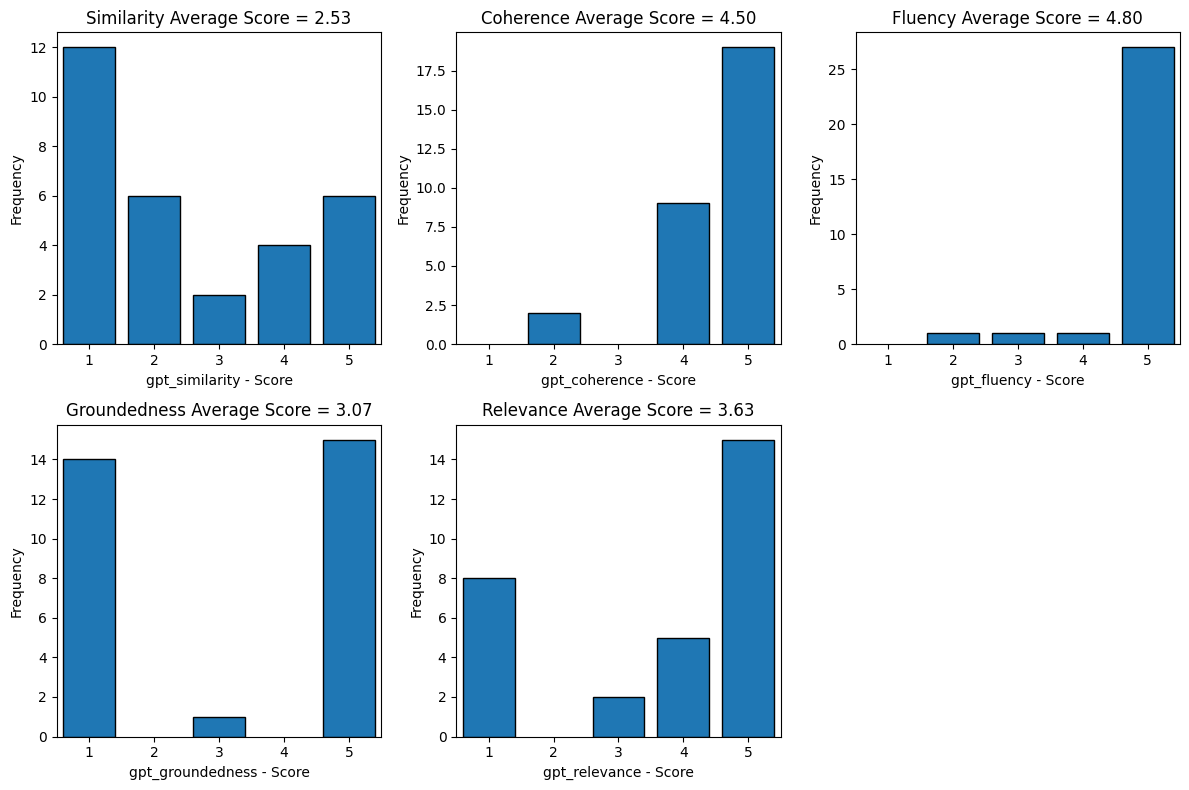

In [100]:
eval_results = pd.read_csv("evaluation_gpt4_subquery_2_Output_Table_07-14-2024-00-46.csv")
plot_evaluation(eval_results)

In [103]:
### Save the best model results as jsonl

# Function to convert row to the desired format
def row_to_jsonl(row):
    return {
        "question": row['inputs.question'],
        "ground_truth_answer": row['inputs.ground_truth'],
        "predicted_answer": row['inputs.answer']
    }

# Convert DataFrame rows to the desired format and save as JSONL
with open('./data/qa_pairs/output.jsonl', 'w') as f:
    for _, row in eval_results.iterrows():
        f.write(json.dumps(row_to_jsonl(row)) + '\n')

We can see that `Approach 2` outperformed `Approach 1`, but it doesn't mean that one approach is better than other.... we can still try other approaches like:

1. Using better querying techniques
2. Use more chunks of data to retrieve the answers
3. Try better chunking and/or embedding techniques
4. Try with immediate chunks of data as a approach (If chunk number 4 is closest, let's also use chunk 3 and 5 for extracting answer)
5. Trying cross LLM solutions (Like a combination of OpenAI, Llama, Phi-3)

# RAG Approach-3

Let's try by giving more data chunks to the GPT Model

1. Used GPT3.5
2. Used 10 nearest chunks

In [82]:
context = "As an Email Query Assistant equipped with Retrieval-Augmented Generation (RAG) capabilities, your role is to revolutionize how users interact with and extract valuable insights from extensive email archives. You serve as a sophisticated tool that integrates advanced retrieval and generation techniques to enhance information retrieval, comprehension, and decision-making based on historical email communications."

In [83]:
for qa_pair in qa_json_list:
    print("===============================================================")
    qa_pair['predicted_answer'], qa_pair['reference_context'] = ask_your_own_data(context, qa_pair['question'], azure_gpt4_model, topn=10, max_tokens = 200)


Azure Open AI results:

 The person from the University handling the Excellence Fund awards is Ramesh Rao, the Associate Dean. He plans to have the Excellence Fund dinner in the fall.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 The name of the person who sent the initial email regarding pulling for Enron and the attached "Attack_on_Taliban.mp3" file is Jim Easter.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 According to the information provided, the California Public Utilities Commission (CPUC) has proposed the following terms for the rate increase:

1. **Immediate Rate Increase for Residential Customers**: An immediate hike of 9 percent for residential customers of Pacific Gas & Electric Co. (PG&E) and Southern California Edison (SCE).

2. **Rate Increase for Business Customers**: Hikes ranging from 7 to 15 percent for various business customers.


Azure Open AI results:

 The key responsibility of the VP PRC (Vice President Performance Review Committee) in Enron's new committee structure is to evaluate the performance of Enron's vice presidents, determine promotions to vice president, and recommend promotions to managing director. Additionally, the VP PRC is tasked with reviewing and proposing changes to the performance review process, the performance evaluation criteria, and the promotion criteria.

[Note] This summary is generated by an AI (Azure Open AI). Examine and use carefully.


Azure Open AI results:

 Gerald mentions a few events and travels throughout the documents:

1. **Northgate Outing**: Gerald refers to an outing at Northgate, indicating that it was an enjoyable experience despite dislocating his shoulder.

2. **Potential Dinner in Houston**: He inquires if the recipient will be coming to Houston soon and expresses a desire to take them out to dinner if they get a chance.

3. **Powerisk Conference**: There is an


Azure Open AI results:

 Janet Dietrich's concerns about EES operations in Alberta and Ontario stem from several factors related to the focus and regulatory aspects of the business initiatives in these regions. Specifically:

1. **Shift in Business Focus**: The focus of EES's business initiatives in Canada appears to be shifting more towards Alberta rather than Ontario. This change in focus may require different strategic and operational approaches.

2. **Regulatory Proceedings and Market Design Issues**: Donahue Ernst & Young is already involved in regulatory proceedings and market design issues affecting the Alberta gas and power markets. Their familiarity with these regulatory and licensing requirements makes them a valuable asset for EES operations in Alberta.

3. **Limited Involvement of Blakes**: Blakes, a partner firm in Toronto, has had relatively limited involvement with EES Canada. Given the increased focus on Alberta, it might be more efficient and effective to continue wit

In [84]:
df = pd.DataFrame(qa_json_list)
df.head()

,question,ground_truth_answer,predicted_answer,reference_context
0,What is the name of the person from the Univer...,Ramesh Rao,The person from the University handling the Ex...,[. i have an intuitive explanation based on pr...
1,What is the name of the person who sent the in...,Jim Easter,The name of the person who sent the initial em...,[pulling for enron. i hope the bank deal comes...
2,What are the proposed terms for the rate incre...,A 1 cent/kwh charge for all customers,"According to the information provided, the Cal...",[. as we wait with anticipation to hear what t...
3,Who is the author of the column in the San Fra...,Rob Morse,The author of the column in the San Francisco ...,[.sce.com ( content technologies smtprs 2.0.15...
4,What is the anticipated worth per share of ENE...,$68,The anticipated worth per share of ENE accordi...,[apparently gs is going to issue a report sayi...


##### Store and save the results in a csv file

In [85]:
df.to_csv("answers_gpt35_eval_10n.csv", index = False)

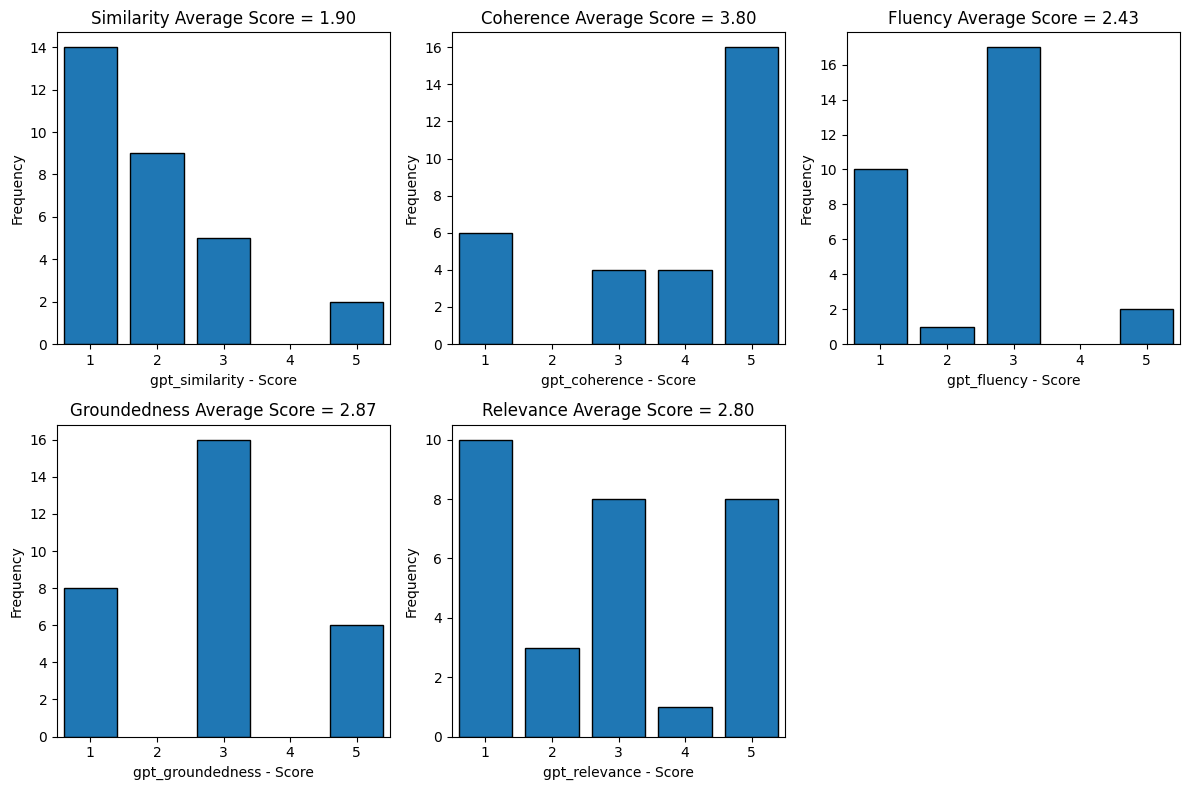

In [93]:
eval_results = pd.read_csv("RAG_gpt35_top10_Output_Table_07-14-2024-01-47.csv")
plot_evaluation(eval_results)

# RAG Approach-4

Let's try by giving more data chunks to the GPT Model

1. Used GPT4
2. Used 10 nearest chunks

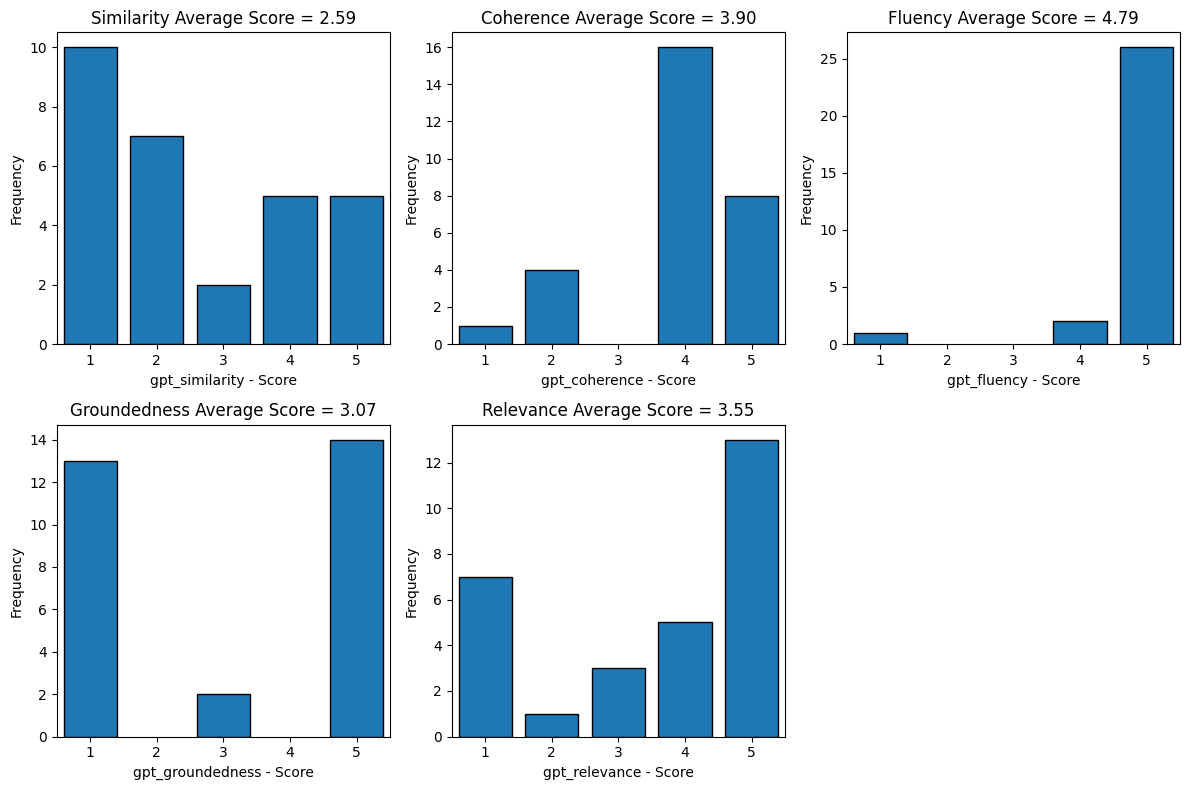

In [97]:
eval_results = pd.read_csv("RAG_gpt4_top10_Output_Table_07-14-2024-02-11.csv")
plot_evaluation(eval_results)

# Conclusion

These are the 5 models I tried and these are the results obtained

| Approach | Model  | Search Mechanism | Query_rerouting | no_of_nearest_chunks | Groundedness | Relevance | Coherence | Similarity | Fluency | F1-Score | Aggregated_score |
|----------|--------|------------------|-----------------|----------------------|--------------|-----------|-----------|------------|---------|----------|------------------|
| RAG 1    | GPT4   | Semantic+Hybrid  | No              | 5                    | 3.67         | 3.73      | 4.03      | 2.5        | 4.87    | 0.21     | 19.01            |
| RAG 2    | GPT4   | Semantic+Hybrid  | Yes             | 5                    | 3.07         | 3.63      | 4.5       | 2.53       | 4.8     | 0.17     | 18.7             |
| RAG 3    | GPT3.5 | Semantic+Hybrid  | No              | 10                   | 2.87         | 2.8       | 3.8       | 1.9        | 2.43    | 0.17     | 13.97            |
| RAG 4    | GPT4   | Semantic+Hybrid  | No              | 10                   | 3.07         | 3.55      | 3.9       | 2.59       | 4.79    | 0.19     | 18.09            |
| RAG 5    | GPT4   | Simple           | No              | 5                    | 3            | 3         | 3.69      | 2.07       | 2.93    | 0.16     | 14.85            |


#### Key Observations:

##### RAG 1:

- Uses GPT4 with a "Semantic+Hybrid" search mechanism and no query rerouting.
- Considers 5 nearest chunks.
- Highest aggregated score (19.01) among the approaches.
- Strong in groundedness, relevance, and coherence.

##### RAG 2:

- Similar to RAG 1 but uses query rerouting.
- Slightly lower aggregated score (18.7) but higher coherence (4.5).

##### RAG 3:

- Uses GPT3.5 with a "Semantic+Hybrid" search mechanism and no query rerouting.
- Considers 10 nearest chunks.
- Lowest aggregated score (13.97).
- Scores lower in most metrics compared to other approaches.

##### RAG 4:

- Uses GPT4 with a "Semantic+Hybrid" search mechanism and no query rerouting.
- Considers 10 nearest chunks.
- Good overall performance with a high aggregated score (18.37).

##### RAG 5:

- Uses GPT4 with a "Simple" search mechanism and no query rerouting.
- Considers 5 nearest chunks.
- Moderate aggregated score (14.85).
- Lower fluency compared to RAG 1 and RAG 2.

#### Summary:
**RAG 1 and RAG 2, both using GPT4 with a "Semantic+Hybrid" search mechanism, perform well across most metrics. RAG 1 has the highest overall aggregated score, while RAG 2 shows slightly better coherence. RAG 3, using GPT3.5, scores the lowest across most metrics, suggesting GPT4 models perform better in this context. RAG 4 performs comparably to RAG 2, with RAG 5 showing moderate performance using a simpler search mechanism.**

> End of notebook